# **Set up and Import Data**


#### 1. Data:
https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014#

#### 2. Electric Demand:
http://www.think-energy.net/KWvsKWH.htm


### Import CSV into Google Colab.

In [1]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import random
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
random.seed(42)

#Mount your Google drive so you can read them easilu
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import fileinput
import os
import zipfile
from six.moves import urllib
import pandas as pd
import fileinput

ZIP_NAME = "LD2011_2014.txt.zip"
DOWNLOAD_ROOT = "https://archive.ics.uci.edu/ml/machine-learning-databases/00321/"
DATASET_PATH = os.path.join("datasets", "Electricity_Load")
DATASET_URL = DOWNLOAD_ROOT + ZIP_NAME
FILE_NAME = "LD2011_2014.txt"

In [3]:
def Electricity_Data(DATASET_url=DATASET_URL, DATASET_path=DATASET_PATH):
    if not os.path.isdir(DATASET_path):
        os.makedirs(DATASET_path)
    file_path = os.path.join(DATASET_path,ZIP_NAME)
    
    urllib.request.urlretrieve(DATASET_URL, file_path) 
    # The commented code above wont execute in proxy settings. Please download the files from UCI
    # https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014#
    Electric_zip = zipfile.ZipFile(file_path, 'r')
    Electric_zip.extractall(DATASET_path)  
    Electric_zip.close()

# Ran the code only once - Since the file is too large - The function call is commented out.
Electricity_Data()

In [4]:
def load_Electricity_data(dataset_path=DATASET_PATH):
    file_path = os.path.join(dataset_path,FILE_NAME)
    with fileinput.FileInput(file_path, inplace=True, backup='.bak') as file:
        for line in file:
            print(line.replace(",", "."), end='')
    return pd.read_csv(file_path, sep=";", index_col=0)
    
data = load_Electricity_data()
fileName = 'LD2011_2014.txt'

In [5]:
# To ensure you have the right data, make sure your data.shape output is (140256, 370). 
# Otherwise, you data file is corrupt and have to read data again. Copy the original file from Saeid's shared Google Drive and run the code again.
data.shape


(140256, 370)

In [6]:
data

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,MT_011,MT_012,MT_013,MT_014,MT_015,MT_016,MT_017,MT_018,MT_019,MT_020,MT_021,MT_022,MT_023,MT_024,MT_025,MT_026,MT_027,MT_028,MT_029,MT_030,MT_031,MT_032,MT_033,MT_034,MT_035,MT_036,MT_037,MT_038,MT_039,MT_040,...,MT_331,MT_332,MT_333,MT_334,MT_335,MT_336,MT_337,MT_338,MT_339,MT_340,MT_341,MT_342,MT_343,MT_344,MT_345,MT_346,MT_347,MT_348,MT_349,MT_350,MT_351,MT_352,MT_353,MT_354,MT_355,MT_356,MT_357,MT_358,MT_359,MT_360,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,129.629630,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 00:30:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,119.212963,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 00:45:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,127.314815,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 01:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,125.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 01:15:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,122.685185,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

# **Data Exploration**

In [7]:
data.tail(2)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,MT_011,MT_012,MT_013,MT_014,MT_015,MT_016,MT_017,MT_018,MT_019,MT_020,MT_021,MT_022,MT_023,MT_024,MT_025,MT_026,MT_027,MT_028,MT_029,MT_030,MT_031,MT_032,MT_033,MT_034,MT_035,MT_036,MT_037,MT_038,MT_039,MT_040,...,MT_331,MT_332,MT_333,MT_334,MT_335,MT_336,MT_337,MT_338,MT_339,MT_340,MT_341,MT_342,MT_343,MT_344,MT_345,MT_346,MT_347,MT_348,MT_349,MT_350,MT_351,MT_352,MT_353,MT_354,MT_355,MT_356,MT_357,MT_358,MT_359,MT_360,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2014-12-31 23:45:00,1.269036,21.337127,1.737619,166.666667,85.365854,285.714286,10.17524,225.589226,64.685315,72.043011,61.847988,161.702128,40.630182,48.500319,61.983471,78.018223,80.862534,335.463259,10.552764,64.317181,206.806283,34.246575,13.852243,45.267490,285.046729,35.593220,39.585871,128.007700,75.767063,60.984570,143.092105,33.994334,60.934891,31.424581,184.247539,10.327022,152.804642,113.874346,50.983248,52.197802,...,74.074074,54.132712,54.639175,15.440041,32.324269,62.992126,132.909483,121.212121,1747.967480,41.025641,638.539043,72.819034,32.515337,49.826188,971.014493,189.655172,0.0,40.69176,108.651911,174.129353,640.000000,23.255814,157.152021,26.052104,272.450533,16.472868,621.212121,214.513557,28.490028,190.789474,246.252677,28000.0,1443.037975,909.090909,26.075619,4.095963,664.618086,146.911519,646.627566,6540.540541
2015-01-01 00:00:00,2.538071,19.914651,1.737619,178.861789,84.146341,279.761905,10.17524,249.158249,62.937063,69.892473,67.809240,163.829787,36.484245,46.585833,61.466942,73.462415,75.471698,319.488818,11.055276,67.841410,185.863874,31.133250,13.192612,45.953361,285.046729,39.830508,38.976857,128.970164,74.514715,58.045555,134.868421,29.272899,60.100167,30.027933,195.499297,8.605852,152.804642,112.565445,52.439913,46.703297,...,72.916667,52.968568,51.030928,14.925373,32.837352,63.976378,129.665948,121.212121,1738.211382,39.560440,555.415617,72.819034,31.901840,49.246813,946.859903,197.768763,0.0,0.00000,108.651911,149.253731,622.222222,23.255814,159.717768,24.048096,267.884323,16.472868,613.636364,217.703349,28.490028,175.438596,188.436831,27800.0,1409.282700,954.545455,27.379400,4.095963,628.621598,131.886477,673.020528,7135.135135


#### As can be seen, the dataframe contains a row for each interval of 15 minutes between Jan 1, 2011 to Dec 31 2014. There are 370 columns corresponding 370 clients. The dataframe is indexed by the timestamp.

Since the frequency is 15 minutes, each day provides $24\times 4 = 96$ datapoints, which multiplied by 365 days and 4 years (plus 1 day in Feb 29, 2012) gives: $96 \times 365 \times 4 + 96 = 140256$, as observed in data.shape

In [8]:
data.describe()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,MT_011,MT_012,MT_013,MT_014,MT_015,MT_016,MT_017,MT_018,MT_019,MT_020,MT_021,MT_022,MT_023,MT_024,MT_025,MT_026,MT_027,MT_028,MT_029,MT_030,MT_031,MT_032,MT_033,MT_034,MT_035,MT_036,MT_037,MT_038,MT_039,MT_040,...,MT_331,MT_332,MT_333,MT_334,MT_335,MT_336,MT_337,MT_338,MT_339,MT_340,MT_341,MT_342,MT_343,MT_344,MT_345,MT_346,MT_347,MT_348,MT_349,MT_350,MT_351,MT_352,MT_353,MT_354,MT_355,MT_356,MT_357,MT_358,MT_359,MT_360,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
count,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,...,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000
mean,3.970785,20.768480,2.918308,82.184490,37.240309,141.227385,4.521338,191.401476,39.975354,42.205152,29.833004,49.304994,55.109965,33.510085,15.163418,24.767073,36.914869,184.004498,6.187150,30.630277,121.762539,20.559679,7.376725,21.406990,163.373989,15.668009,14.982383,50.404422,58.850349,15.438616,67.355325,15.411176,24.848862,10.546950,87.882419,27.421373,83.373382,89.883837,13.055790,74.713009,...,221.827103,29.308875,63.745554,61.005710,54.978062,121.346269,31.362774,183.641656,2442.715562,100.342822,779.187866,204.096524,113.719204,130.361406,1565.976941,215.019347,1.844880,13.065485,144.052901,484.308083,1230.459794,77.096923,391.253968,90.126873,495.260113,82.164381,1408.881714,605.108383,81.531754,388.224080,218.213701,37607.987537,1887.427366,2940.031734,65.413150,9.269709,424.262904,94.704717,625.251734,8722.355145
std,5.983965,13.272415,11.014456,58.248392,26.461327,98.439984,6.485684,121.981187,29.814595,33.401251,20.347314,73.944242,48.044556,24.893022,23.555069,17.444889,24.282106,129.601771,4.200317,20.296580,82.811164,16.318638,5.507214,16.796146,114.749587,11.776842,11.001116,34.640532,43.366687,19.886410,45.064948,16.276663,21.896184,7.282169,58.235655,27.744751,57.795972,57.850121,21.827919,66.964774,...,80.838968,50.855355,46.935750,55.642929,53.671725,93.759147,61.485026,137.645418,2128.834941,93.301250,643.070730,182.112867,129.876419,128.555531,1175.512494,169.195334,4.086486,23.091625,134.333083,511.598370,1105.148746,95.232817,279.646061,99.558309,442.743660,108.329230,1243.202736,576.699851,85.363563,347.626599,204.833532,38691.954832,1801.486488,2732.251967,65.007818,10.016782,274.337122,80.297301,380.656042,9195.155777
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

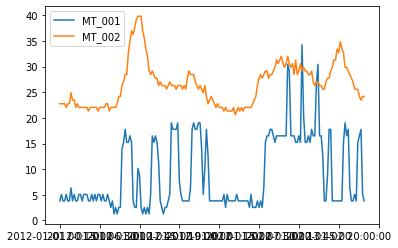

In [9]:
data_example = data.loc['2012-01-01 00:15:00':'2012-01-03 00:00:00'][['MT_001','MT_002']]
data_example.plot()
plt.show()

### Plot the 2 days of 2012 for the first 2 clients

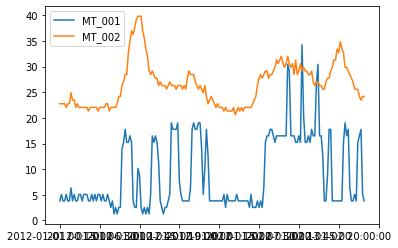

In [10]:
data_example = data.loc['2012-01-01 00:15:00':'2012-01-03 00:00:00'][['MT_001','MT_002']]
data_example.plot()
plt.show()

#### Very Important Note: 
We quickly note that the main difference between the curves is the level (also seen on the means in df.describe()), so we know we will have to somehow normalize the curves, in order for the clustering technique to capture the behaviour of the consumption throughout the day, rather than the overall level.

### Data for the analysis

We focus on 2013 and 2014 because these are the years with lower number of clients having zero demand

In [11]:
data2011 = data.loc['2011-01-01 00:15:00':'2012-01-01 00:00:00']
data2012 = data.loc['2012-01-01 00:15:00':'2013-01-01 00:00:00']
data2013 = data.loc['2013-01-01 00:15:00':'2014-01-01 00:00:00']
data2014 = data.loc['2014-01-01 00:15:00':'2015-01-01 00:00:00']

Ensure that all datasets have data for full year

In [12]:
print(data2011.shape[0]/96)
print(data2012.shape[0]/96)
print(data2013.shape[0]/96)
print(data2014.shape[0]/96)

365.0
366.0
365.0
365.0


See if we have clients who never consumed energy in a year, these are instances without any values

In [13]:
print(sum(data2011.mean()==0))
print(sum(data2012.mean()==0))
print(sum(data2013.mean()==0))
print(sum(data2014.mean()==0))

210
37
21
1


# **Prepare dataset**

### Remove instances with value=0 
They're only a handful of them relative to datasets they belong to, so there is no significant impact in dropping them

In [14]:
clients = data2011.columns
clients_no_demand = clients[data2013.mean()==0] # clients with 0 demand

# Add data of 2014 at the end of df consist of 2013 data

data_13_14 = data2013.append(data2014) # appending 2013 and 2014

# drop clients with 0 demand
data_13_14 = data_13_14.drop(clients_no_demand, axis=1) 
print(data_13_14.shape)
print(sum(data_13_14.mean()==0)) # check that there are no clients with 0 demand

(70080, 349)
0


In [15]:
data_13_14.copy()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,MT_011,MT_012,MT_013,MT_014,MT_015,MT_016,MT_017,MT_018,MT_019,MT_020,MT_021,MT_022,MT_023,MT_024,MT_025,MT_026,MT_027,MT_028,MT_029,MT_030,MT_031,MT_032,MT_033,MT_034,MT_035,MT_036,MT_037,MT_038,MT_039,MT_040,...,MT_329,MT_330,MT_331,MT_332,MT_333,MT_334,MT_335,MT_336,MT_338,MT_339,MT_340,MT_341,MT_342,MT_343,MT_344,MT_345,MT_346,MT_348,MT_349,MT_350,MT_351,MT_352,MT_353,MT_354,MT_355,MT_356,MT_357,MT_358,MT_359,MT_360,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2013-01-01 00:15:00,2.538071,22.759602,2.606429,138.211382,63.414634,255.952381,4.522329,239.057239,57.692308,78.494624,61.847988,0.000000,38.142620,33.822591,0.000000,39.293850,70.080863,341.853035,11.055276,57.268722,143.979058,31.133250,15.171504,32.235940,299.065421,27.118644,25.578563,93.358999,67.000626,0.000000,115.131579,50.047214,50.918197,26.536313,135.021097,17.211704,119.922631,99.476440,0.000000,175.824176,...,136.985294,44.45625,175.925926,2.910361,43.298969,19.042717,29.758851,90.551181,86.580087,1583.739837,34.432234,348.866499,75.702956,31.288344,67.786790,932.367150,125.760649,0.00000,91.549296,174.129353,653.333333,45.011253,192.431046,20.040080,389.649924,19.379845,734.848485,405.103668,35.612536,174.342105,64.953605,22300.0,886.075949,1000.000000,16.949153,6.436513,616.330114,76.794658,731.671554,8086.486486
2013-01-01 00:30:00,1.269036,22.759602,2.606429,138.211382,63.414634,264.880952,5.652911,228.956229,57.692308,76.344086,64.828614,0.000000,43.946932,35.737077,0.000000,38.724374,72.776280,335.463259,9.547739,52.863436,151.832461,28.642590,13.192612,34.979424,294.392523,24.576271,24.360536,91.434071,63.869756,0.000000,118.421053,47.214353,52.587646,26.536313,135.021097,15.490534,127.659574,102.094241,0.000000,173.076923,...,131.102941,43.83125,157.407407,2.910361,43.298969,18.013381,29.245767,92.519685,90.909091,1536.585366,32.967033,342.569270,75.702956,31.288344,71.263036,917.874396,121.703854,40.69176,70.925553,149.253731,653.333333,45.761440,191.148172,20.040080,340.943683,19.379845,742.424242,385.964912,35.612536,164.473684,61.384725,21000.0,864.978903,909.090909,18.252934,3.510825,564.530290,76.794658,727.272727,8086.486486
2013-01-01 00:45:00,2.538071,22.759602,2.606429,134.146341,60.975610,250.000000,5.652911,239.057239,54.195804,76.344086,62.593145,0.000000,39.800995,33.822591,0.000000,41.002278,69.182390,380.191693,11.557789,50.220264,151.832461,27.397260,12.532982,32.921811,299.065421,26.271186,26.187576,95.283927,62.617408,0.000000,111.842105,44.381492,52.587646,27.234637,130.801688,13.769363,125.725338,104.712042,0.000000,175.824176,...,134.044118,55.09375,146.990741,2.910361,43.298969,17.498713,29.245767,92.519685,90.909091,1551.219512,32.967033,328.715365,74.260995,30.674847,63.731170,903.381643,119.675456,0.00000,64.386318,174.129353,648.888889,39.009752,184.733804,19.038076,284.627093,21.317829,719.696970,334.928230,35.612536,163.377193,42.826552,18200.0,860.759494,840.909091,16.949153,5.851375,590.869183,68.447412,730.205279,7848.648649
2013-01-01 01:00:00,1.269036,23.470839,2.606429,130.081301,56.097561,226.190476,6.218202,249.158249,50.699301,75.268817,59.612519,0.000000,37.313433,34.460753,0.000000,41.571754,63.791554,351.437700,11.055276,58.149780,167.539267,24.906600,11.873351,32.921811,289.719626,24.576271,27.405603,88.546679,61.991234,0.000000,103.618421,44.381492,53.422371,25.139665,119.549930,15.490534,119.922631,107.329843,0.000000,170.329670,...,125.205882,46.33125,179.398148,2.910361,42.783505,17.498713,29.245767,91.535433,90.909091,1156.097561,32.967033,332.493703,72.819034,30.674847,61.993048,884.057971,120.689655,40.69176,63.883300,174.129353,635.555556,39.009752,187.940988,19.038076,252.663623,30.038760,712.121212,334.928230,35.612536,162.280702,44.254104,15800.0,860.759494,840.909091,16.949153,4.095963,575.065847,58.430718,722.873900,7848.648649
2013-01-01 01:15:00,3.807107,23.470839,2.606429,130.081301,58.536585,2

## Normalize the data

### Getting average curves per client

In [16]:
data = data_13_14.copy() # weekdays weekends, data2011, data2012, data2013, data2014

In [17]:
data.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,MT_011,MT_012,MT_013,MT_014,MT_015,MT_016,MT_017,MT_018,MT_019,MT_020,MT_021,MT_022,MT_023,MT_024,MT_025,MT_026,MT_027,MT_028,MT_029,MT_030,MT_031,MT_032,MT_033,MT_034,MT_035,MT_036,MT_037,MT_038,MT_039,MT_040,...,MT_329,MT_330,MT_331,MT_332,MT_333,MT_334,MT_335,MT_336,MT_338,MT_339,MT_340,MT_341,MT_342,MT_343,MT_344,MT_345,MT_346,MT_348,MT_349,MT_350,MT_351,MT_352,MT_353,MT_354,MT_355,MT_356,MT_357,MT_358,MT_359,MT_360,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2013-01-01 00:15:00,2.538071,22.759602,2.606429,138.211382,63.414634,255.952381,4.522329,239.057239,57.692308,78.494624,61.847988,0.0,38.142620,33.822591,0.0,39.293850,70.080863,341.853035,11.055276,57.268722,143.979058,31.133250,15.171504,32.235940,299.065421,27.118644,25.578563,93.358999,67.000626,0.0,115.131579,50.047214,50.918197,26.536313,135.021097,17.211704,119.922631,99.476440,0.0,175.824176,...,136.985294,44.45625,175.925926,2.910361,43.298969,19.042717,29.758851,90.551181,86.580087,1583.739837,34.432234,348.866499,75.702956,31.288344,67.786790,932.367150,125.760649,0.00000,91.549296,174.129353,653.333333,45.011253,192.431046,20.040080,389.649924,19.379845,734.848485,405.103668,35.612536,174.342105,64.953605,22300.0,886.075949,1000.000000,16.949153,6.436513,616.330114,76.794658,731.671554,8086.486486
2013-01-01 00:30:00,1.269036,22.759602,2.606429,138.211382,63.414634,264.880952,5.652911,228.956229,57.692308,76.344086,64.828614,0.0,43.946932,35.737077,0.0,38.724374,72.776280,335.463259,9.547739,52.863436,151.832461,28.642590,13.192612,34.979424,294.392523,24.576271,24.360536,91.434071,63.869756,0.0,118.421053,47.214353,52.587646,26.536313,135.021097,15.490534,127.659574,102.094241,0.0,173.076923,...,131.102941,43.83125,157.407407,2.910361,43.298969,18.013381,29.245767,92.519685,90.909091,1536.585366,32.967033,342.569270,75.702956,31.288344,71.263036,917.874396,121.703854,40.69176,70.925553,149.253731,653.333333,45.761440,191.148172,20.040080,340.943683,19.379845,742.424242,385.964912,35.612536,164.473684,61.384725,21000.0,864.978903,909.090909,18.252934,3.510825,564.530290,76.794658,727.272727,8086.486486
2013-01-01 00:45:00,2.538071,22.759602,2.606429,134.146341,60.975610,250.000000,5.652911,239.057239,54.195804,76.344086,62.593145,0.0,39.800995,33.822591,0.0,41.002278,69.182390,380.191693,11.557789,50.220264,151.832461,27.397260,12.532982,32.921811,299.065421,26.271186,26.187576,95.283927,62.617408,0.0,111.842105,44.381492,52.587646,27.234637,130.801688,13.769363,125.725338,104.712042,0.0,175.824176,...,134.044118,55.09375,146.990741,2.910361,43.298969,17.498713,29.245767,92.519685,90.909091,1551.219512,32.967033,328.715365,74.260995,30.674847,63.731170,903.381643,119.675456,0.00000,64.386318,174.129353,648.888889,39.009752,184.733804,19.038076,284.627093,21.317829,719.696970,334.928230,35.612536,163.377193,42.826552,18200.0,860.759494,840.909091,16.949153,5.851375,590.869183,68.447412,730.205279,7848.648649
2013-01-01 01:00:00,1.269036,23.470839,2.606429,130.081301,56.097561,226.190476,6.218202,249.158249,50.699301,75.268817,59.612519,0.0,37.313433,34.460753,0.0,41.571754,63.791554,351.437700,11.055276,58.149780,167.539267,24.906600,11.873351,32.921811,289.719626,24.576271,27.405603,88.546679,61.991234,0.0,103.618421,44.381492,53.422371,25.139665,119.549930,15.490534,119.922631,107.329843,0.0,170.329670,...,125.205882,46.33125,179.398148,2.910361,42.783505,17.498713,29.245767,91.535433,90.909091,1156.097561,32.967033,332.493703,72.819034,30.674847,61.993048,884.057971,120.689655,40.69176,63.883300,174.129353,635.555556,39.009752,187.940988,19.038076,252.663623,30.038760,712.121212,334.928230,35.612536,162.280702,44.254104,15800.0,860.759494,840.909091,16.949153,4.095963,575.065847,58.430718,722.873900,7848.648649
2013-01-01 01:15:00,3.807107,23.470839,2.606429,130.081301,58.536585,229.166667,6.783493,239.057239,57.692308,74.193548,64.828614,0.0,44.776119,35.737

In [18]:
data['hour'] = data.index.map(lambda x: x[11:])

In [19]:
datagrouped = data.groupby("hour")
average_curves = datagrouped.agg("mean")
average_curves.shape 
average_curves.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,MT_011,MT_012,MT_013,MT_014,MT_015,MT_016,MT_017,MT_018,MT_019,MT_020,MT_021,MT_022,MT_023,MT_024,MT_025,MT_026,MT_027,MT_028,MT_029,MT_030,MT_031,MT_032,MT_033,MT_034,MT_035,MT_036,MT_037,MT_038,MT_039,MT_040,...,MT_329,MT_330,MT_331,MT_332,MT_333,MT_334,MT_335,MT_336,MT_338,MT_339,MT_340,MT_341,MT_342,MT_343,MT_344,MT_345,MT_346,MT_348,MT_349,MT_350,MT_351,MT_352,MT_353,MT_354,MT_355,MT_356,MT_357,MT_358,MT_359,MT_360,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
hour,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00:00:00,5.008344,26.045909,1.938755,130.551843,60.374206,191.136660,7.772366,242.027582,51.585401,54.837237,42.262622,88.726319,46.342488,36.804469,27.339947,37.757044,46.259031,233.244343,8.727886,47.221049,157.293983,23.349085,10.342646,30.964729,205.274613,24.901323,25.411710,77.238388,73.936576,36.661198,84.744503,28.798168,39.307522,18.857618,121.582567,21.189258,122.389444,104.733558,28.613475,79.643986,...,144.845266,53.765788,109.711124,25.563334,89.332721,49.267127,35.202457,85.837558,147.067544,2999.331774,80.969442,772.007522,178.349843,39.246996,88.554580,2009.403746,307.028536,25.529899,137.375624,194.745451,769.826484,100.636118,421.909021,54.916683,552.467630,36.967718,1115.390203,786.599594,49.238965,342.114275,119.625903,36306.438356,1333.223513,1652.677460,37.831080,16.499275,676.790504,148.683880,799.235729,17333.891151
00:15:00,4.917947,25.833512,1.911381,125.863125,57.586034,179.297130,7.426996,232.516950,50.016764,53.424658,40.008779,84.153308,48.014494,36.523852,26.080465,35.927700,44.359931,218.862970,8.254285,45.631525,147.357097,23.063341,9.710124,29.100663,193.906030,23.796146,24.031001,74.074123,72.246764,34.882691,80.008562,28.173387,37.487136,18.251129,116.162842,20.899253,115.693808,99.677257,26.637999,75.974710,...,135.636281,52.267671,112.044964,24.030013,65.792967,34.538456,32.738250,80.271815,142.323430,2666.673349,76.118220,620.409924,151.621219,37.688041,75.400403,1919.647939,286.154103,43.478867,127.241531,181.557964,730.124810,95.728042,420.353757,52.186565,492.702404,35.421313,1005.738896,577.003998,51.676228,291.687695,119.540837,32137.534247,979.064794,1443.711083,33.942955,16.580232,659.875882,155.464587,795.100028,17466.227323
00:30:00,4.984007,24.754964,1.909001,121.566990,55.476111,171.554958,7.179972,225.317098,48.843280,52.514361,38.368414,82.745555,49.468411,36.522104,25.151421,34.440041,42.625755,210.184253,7.923866,44.923058,141.285950,22.361350,9.210431,28.069978,185.174754,22.319480,22.787112,72.068770,70.764533,33.656759,76.613194,27.670198,36.427150,17.709689,111.388552,20.477212,110.193159,95.469053,25.415798,72.790908,...,132.261765,52.212466,104.945142,22.680881,64.622228,29.199303,32.277880,79.856542,136.968511,2321.122619,70.681921,599.389255,134.323612,36.445920,72.010667,1780.821918,258.416461,34.114188,106.183677,175.560553,705.071537,94.535963,490.040156,51.317704,432.933008,34.154986,790.421337,446.283673,78.827616,262.020848,111.557303,27249.178082,938.598925,1324.501868,31.044275,15.940589,655.911819,153.879754,777.630258,17605.301740
00:45:00,4.980530,24.656560,1.899480,117.961354,53.630137,164.452870,7.013482,218.698400,47.574001,51.150390,36.864831,80.772370,47.148958,35.771171,24.148789,32.935220,40.818964,200.700249,7.610656,43.794581,136.864376,20.430236,8.741461,27.015803,179.400845,21.013466,21.816862,70.269094,69.844143,31.808803,73.693223,27.449002,34.913212,17.368179,107.244283,20.493717,107.127527,91.782615,24.297359,70.976968,...,131.051309,52.040916,106.806507,21.641922,63.032764,28.299692,31.671317,79.322619,119.901560,1778.561087,50.988007,491.480625,108.471027,35.470208,64.063715,1381.616041,181.762483,29.320364,90.574268,171.539562,654.940639,86.802865,508.876431,51.352019,330.041075,31.472337,743.244085,314.009963,68.352652,221.497236,97.361963,24234.109589,837.292642,1134.433375,30.245932,15.121396,644

#### The dataframe average_curves contains the 349 typical weekday electric demands

#### We now divide each curve by its mean, so that all curves have mean 1. Each curve is one client. In setting means to 1 , all clients will have a common baseline

In [20]:
average_curves_norm = average_curves/(average_curves.mean())


In [21]:
t = average_curves_norm.reset_index()
t.iloc[-1,:]


hour      23:45:00
MT_001     1.00163
MT_002     0.92657
MT_003    0.993017
MT_004     1.17529
            ...   
MT_366     1.32444
MT_367     1.22727
MT_368     1.13638
MT_369    0.974611
MT_370    0.987431
Name: 95, Length: 350, dtype: object

In [22]:
average_curves_norm.loc[:,'MT_004']

hour
00:00:00    1.140106
00:15:00    1.099159
00:30:00    1.061641
00:45:00    1.030153
01:00:00    0.975761
              ...   
22:45:00    1.347294
23:00:00    1.293558
23:15:00    1.238946
23:30:00    1.209744
23:45:00    1.175290
Name: MT_004, Length: 96, dtype: float64

#### Plot the first 2 and last 2 clients. Notice in the plot that all clients plotted have the same baseline of 1

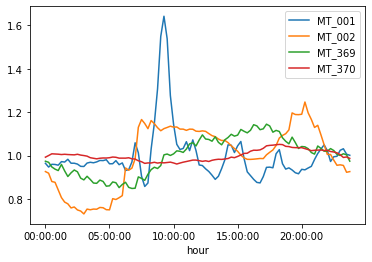

In [23]:
average_curves_norm[['MT_001','MT_002','MT_369','MT_370']].plot()
plt.show()

In [24]:
average_curves_norm

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,MT_011,MT_012,MT_013,MT_014,MT_015,MT_016,MT_017,MT_018,MT_019,MT_020,MT_021,MT_022,MT_023,MT_024,MT_025,MT_026,MT_027,MT_028,MT_029,MT_030,MT_031,MT_032,MT_033,MT_034,MT_035,MT_036,MT_037,MT_038,MT_039,MT_040,...,MT_329,MT_330,MT_331,MT_332,MT_333,MT_334,MT_335,MT_336,MT_338,MT_339,MT_340,MT_341,MT_342,MT_343,MT_344,MT_345,MT_346,MT_348,MT_349,MT_350,MT_351,MT_352,MT_353,MT_354,MT_355,MT_356,MT_357,MT_358,MT_359,MT_360,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
hour,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00:00:00,0.964792,0.926674,0.991800,1.140106,1.186498,1.008914,1.170686,0.946572,0.983915,0.948867,1.067727,0.899154,0.594005,0.812633,0.900893,1.139499,0.942227,0.943290,1.071027,1.112666,0.976258,0.826026,1.041795,0.979740,0.950892,1.198976,1.223172,1.135498,0.922252,1.186509,0.956077,1.025583,0.969207,1.309342,1.023562,0.567422,1.092313,0.874111,1.095065,0.945736,...,0.710134,0.567060,0.555638,0.447612,1.029641,0.593204,0.476664,0.540194,0.603108,0.923516,0.603549,0.753769,0.710593,0.261940,0.513765,0.985052,1.080529,1.775050,0.713224,0.319943,0.486279,1.072717,0.826119,0.439183,0.845824,0.372696,0.609931,1.022005,0.602145,0.678209,0.414676,0.748555,0.561491,0.430085,0.471574,1.358632,1.215272,1.170441,0.974307,0.992967
00:15:00,0.947378,0.919117,0.977796,1.099159,1.131703,0.946419,1.118666,0.909376,0.953996,0.924425,1.010786,0.852811,0.615436,0.806437,0.859391,1.084290,0.903545,0.885129,1.012910,1.075212,0.914584,0.815918,0.978083,0.920760,0.898229,1.145762,1.156713,1.088980,0.901174,1.128949,0.902647,1.003333,0.924322,1.267231,0.977935,0.559656,1.032555,0.831911,1.019462,0.902165,...,0.664985,0.551260,0.567458,0.420764,0.758324,0.415863,0.443297,0.505168,0.583653,0.821088,0.567388,0.605753,0.604099,0.251535,0.437449,0.941051,1.007065,3.023012,0.660610,0.298278,0.461200,1.020400,0.823074,0.417349,0.754324,0.357106,0.549971,0.749683,0.631951,0.578244,0.414381,0.662602,0.412336,0.375704,0.423108,1.365299,1.184899,1.223818,0.969266,1.000548
00:30:00,0.960104,0.880744,0.976579,1.061641,1.090238,0.905552,1.081459,0.881217,0.931614,0.908674,0.969343,0.838545,0.634072,0.806398,0.828778,1.039392,0.868223,0.850030,0.972363,1.058519,0.876902,0.791083,0.927749,0.888148,0.857783,1.074662,1.096839,1.059499,0.882685,1.089273,0.864340,0.985413,0.898186,1.229638,0.937742,0.548354,0.983462,0.796789,0.972687,0.864359,...,0.648441,0.550678,0.531500,0.397140,0.744830,0.351576,0.437064,0.502555,0.561693,0.714690,0.526866,0.585229,0.535181,0.243245,0.417783,0.872996,0.909448,2.371901,0.551282,0.288425,0.445375,1.007694,0.959523,0.410401,0.662818,0.344339,0.432228,0.579843,0.963986,0.519432,0.386706,0.561815,0.395294,0.344682,0.386975,1.312627,1.177781,1.211343,0.947969,1.008515
00:45:00,0.959434,0.877243,0.971708,1.030153,1.053960,0.868064,1.056382,0.855331,0.907404,0.885073,0.931357,0.818549,0.604342,0.789818,0.795739,0.993977,0.831421,0.811675,0.933928,1.031928,0.849460,0.722766,0.880511,0.854794,0.831037,1.011779,1.050137,1.033041,0.871205,1.029465,0.831398,0.977535,0.860856,1.205926,0.902852,0.548796,0.956102,0.766022,0.929884,0.842819,...,0.642507,0.548868,0.540927,0.378948,0.726510,0.340744,0.428850,0.499194,0.491703,0.547632,0.380067,0.479870,0.432177,0.236733,0.371677,0.677297,0.639679,2.038595,0.470241,0.281819,0.413709,0.925264,0.996405,0.410675,0.505291,0.317293,0.406430,0.407983,0.835887,0.439098,0.337499,0.499651,0.352628,0.295219,0.377024,1.245171,1.156699,1.189829,0.937889,1.007613
01:00:00,0.956085,0.841989,0.953443,0.975761,1.024347,0.822656,1.030838,0.830275,0.888265,0.869041,0.898064,0.802658,0.574845,0.763413,0.770768,0.965608,0.800586,0.772275,0.907320,0.992228,0.821972,0.704117,0.838825,0.826522,0.811437,0.960131,0.995524,0.993714,0.853037,1.001223,0.803945,0.997068,0.828038,1.181616,0.866682,0.543934,0.929947,0.751431,0.882536,0.821145,...,0.636550,0.530001,0.551880,0.373950,0.699937

# **Building and Training Clustering Model**

# Looking at energy demand from a different time dimension: **hourly**

In [25]:
X = average_curves_norm.copy()
X = np.array(X.T) # put it on the right format
average_curves_norm.shape
## one array = one customer

(96, 349)

In [26]:
len(X)

349

## Clustering Analysis on the average normizalied curves

Determine what is the optimal number of clusters based on _intertia_ and based on _silhouette_.

In [27]:


def getInertia(X,kmeans):
    ''' This function returns the exact same value as the attribute inertia_ of kmeans'''
    inertia = 0
    for J in range(len(X)):
        inertia = inertia + np.linalg.norm(X[J] - kmeans.cluster_centers_[kmeans.labels_[J]])**2
    return inertia


def getOptimalClusters(X, max_K=len(X)):
  # # find which random points to consider centroid
  # centroids = random.sample(range(0, len(X)), kmeans)
  # #for each instance in X, find closestr centroid to it
  global inertias_1, silhouette_avgs
  inertias_1 = []
  silhouette_avgs = []
  max_K = 15
  for k in np.arange(1,max_K+1):
      # print(k)
      kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
      # print(inertias_1)
      inertias_1 = inertias_1 + [kmeans.inertia_]
      # print(inertias_1)
      
      if k>1: ## silhouette will only exist if there are more than 1 cluster in an X
          # print(kmeans.labels_)
          sil_score = [silhouette_score(X, kmeans.labels_)]
          # print("Silhoutte Score: ", sil_score)
          silhouette_avgs = silhouette_avgs + sil_score
      # print("----")
  
getOptimalClusters(X, max_K=15)
print("Max. Silhouette Average: ", np.max(silhouette_avgs))
print("Min. Inertia 1 Average: ",np.min(inertias_1))


print("Silhouette Averafes: ", silhouette_avgs)
print("Inertia Averages: ", inertias_1)

silhouette_plt = pd.DataFrame(silhouette_avgs, columns=['Silhouette']).reset_index()
inertias_plt = pd.DataFrame(inertias_1, columns=['Inertia']).reset_index()



Max. Silhouette Average:  0.43490147121537626
Min. Inertia 1 Average:  281.7917408771587
Silhouette Averafes:  [0.37191838565388774, 0.42244692513476645, 0.4296355372224772, 0.43490147121537626, 0.4289726637003935, 0.39571826158729223, 0.27077911430989965, 0.2508538342044547, 0.2415068181174098, 0.22748152708168196, 0.19488138331759897, 0.19885167737714424, 0.20730197214714066, 0.2088637230205947]
Inertia Averages:  [1707.229420029633, 1175.5272754230882, 865.9677208804297, 657.6442657822121, 553.8272084963303, 476.48468035158305, 426.68223434503193, 391.5105843120735, 368.04244042810456, 350.29800203582187, 330.1187699890719, 313.91892542640903, 302.7337864922732, 293.65866457011754, 281.7917408771587]


## Plot Silhoutte and Inertia 1's


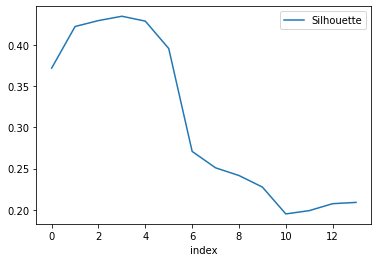

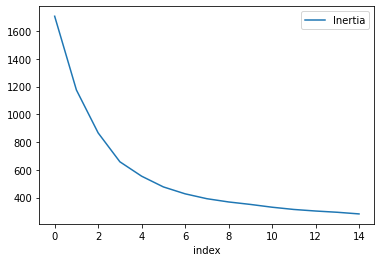

In [28]:
import matplotlib.pyplot as plt
silhouette_plt.plot(x='index',y='Silhouette')

inertias_plt.plot(x='index',y='Inertia')

* Optimal # of clusters based on silhouette: 2 to 4
* Optimal # of clusers based on inertia 1: 3 to 6

## Plot the instances belonging to each cluster
Includes:
* The number of clients in the cluster (you can put this in the title of the plot)
* All the curves in the cluster
* The curve corresponding to the centroid of the cluster (make this curve thicker to distinguish it from the individual curves)



### These are cluster #1 points


In [34]:
from itertools import compress 
k=6
kmeans = KMeans(n_clusters=k)
X = average_curves_norm.copy()
X=np.array(X.T)
y_pred = kmeans.fit_predict(X)
y_pred is kmeans.labels_
kmeans.labels_ # represents the cluster index each instance gets assigned to



array([1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 0,
       4, 4, 4, 4, 4, 4, 1, 4, 4, 1, 4, 4, 4, 0, 4, 0, 4, 4, 4, 4, 4, 4,
       0, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 0, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4,
       4, 1, 1, 0, 5, 1, 0, 0, 0, 3, 3, 3, 3, 1, 3, 3, 3, 4, 0, 1, 0, 4,
       3, 0, 1, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 4, 4, 1, 4, 1, 4, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

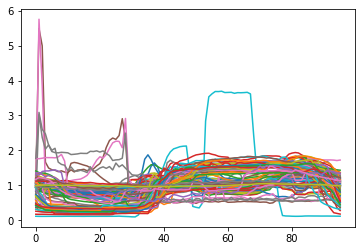

In [35]:
labels = pd.DataFrame({'Customer': average_curves_norm.columns, 'Cluster Idx': kmeans.labels_})
cluster_1= pd.DataFrame(list(compress(X, kmeans.labels_))).T
cluster_1.plot(legend=None)

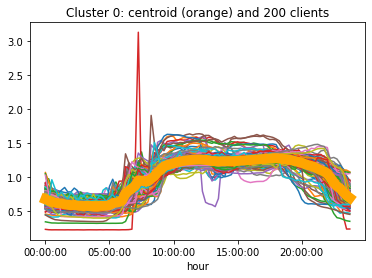

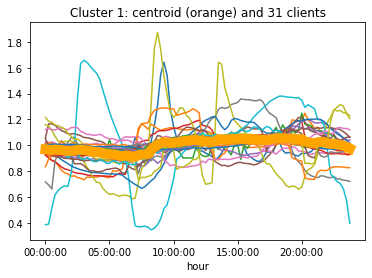

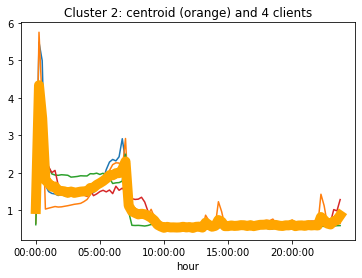

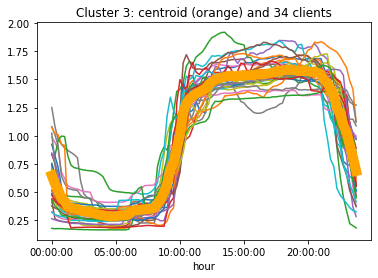

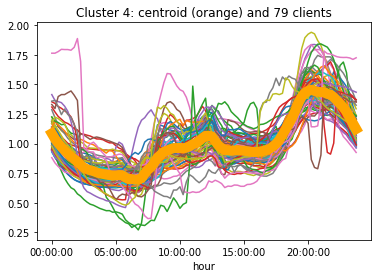

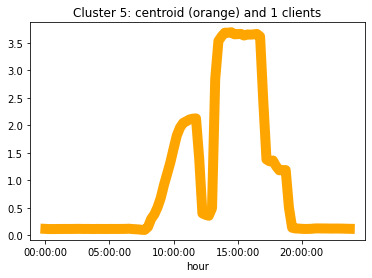

In [36]:
# Plots
for c in range(k) :    
    average_curves_norm.T[kmeans.labels_==c].T.plot(legend=False)
    plt.plot(kmeans.cluster_centers_[c], linewidth=10, color='orange')
    plt.title("Cluster "+str(c)+": centroid (orange) and "+str(sum(kmeans.labels_==c))+" clients")
    plt.show()

In [45]:
cluster_1 = labels[labels['Cluster Idx']==1]['Customer'].tolist()
cluster_1[0:5] ## to show some of them

['MT_001', 'MT_002', 'MT_003', 'MT_029', 'MT_032']

In [46]:
average_curves_norm.copy().loc[:,cluster_1]

,MT_001,MT_002,MT_003,MT_029,MT_032,MT_059,MT_090,MT_091,MT_094,MT_102,MT_119,MT_127,MT_129,MT_141,MT_142,MT_143,MT_144,MT_145,MT_146,MT_147,MT_148,MT_149,MT_150,MT_152,MT_154,MT_157,MT_161,MT_163,MT_367,MT_369,MT_370
hour,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00:00:00,0.964792,0.926674,0.991800,0.922252,1.025583,1.054425,1.014254,0.715442,1.157314,0.383748,0.995048,0.832952,0.959180,0.961338,0.987630,0.947296,0.989549,0.983254,0.988249,0.969620,0.956137,1.013310,0.986838,0.928703,1.005685,1.051803,1.120121,0.972766,1.215272,0.974307,0.992967
00:15:00,0.947378,0.919117,0.977796,0.901174,1.003333,1.165323,1.018558,0.691711,1.149847,0.389149,0.966770,0.892283,0.959530,0.961741,0.960421,0.934188,0.988993,0.991509,0.988669,0.966642,0.952585,1.017474,0.992202,0.928293,0.989102,0.999646,1.128060,0.960805,1.184899,0.969266,1.000548
00:30:00,0.960104,0.880744,0.976579,0.882685,0.985413,1.164561,1.025337,0.661464,1.114457,0.511244,0.946627,0.915762,0.953847,0.970488,0.952158,0.919206,0.987402,0.976710,0.988598,0.965152,0.950521,1.015863,1.003559,0.925605,0.998048,0.967955,1.119362,0.948122,1.177781,0.947969,1.008515
00:45:00,0.959434,0.877243,0.971708,0.871205,0.977535,1.153133,1.017138,0.878484,1.070112,0.616298,0.929110,0.917557,0.947446,0.963625,0.950977,0.911116,0.985322,0.974267,0.986740,0.963967,0.950400,1.004668,0.980911,0.924947,1.003242,0.990282,1.118717,0.969680,1.156699,0.937889,1.007613
01:00:00,0.956085,0.841989,0.953443,0.853037,0.997068,1.131842,0.996340,0.933091,1.030573,0.650393,0.905250,0.918068,0.944821,0.957570,0.928471,0.911064,0.985970,0.970220,0.985374,0.961665,0.948561,1.003804,0.983063,0.922544,1.002325,0.997263,1.126488,0.976560,1.149629,0.931284,1.006770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22:45:00,0.996941,0.955618,1.038072,1.034618,1.100395,1.129193,0.940809,0.739267,1.293009,0.719267,1.089049,0.832788,0.980407,0.961741,1.039992,1.022939,0.991510,0.989152,0.993616,0.983030,0.969137,1.011582,0.993791,0.935083,1.010137,1.050537,1.132170,0.940843,1.265394,1.005845,1.013001
23:00:00,1.024736,0.957767,1.009456,1.022709,1.080034,1.120715,0.939559,0.738632,1.314123,0.703886,1.073225,0.832804,0.981326,0.960261,1.031595,1.010551,0.990563,0.987397,0.990232,0.982728,0.973642,1.016099,0.994189,0.933061,1.008609,1.039068,1.136693,0.946044,1.268087,1.000981,1.004462
23:15:00,1.031768,0.954925,1.003976,1.003857,1.051611,1.104622,0.949204,0.728757,1.301134,0.662666,1.057876,0.829558,0.968454,0.958512,1.030567,0.992445,0.989569,0.987580,0.991848,0.974109,0.968084,1.027019,0.993725,0.930953,1.005685,1.048654,1.129753,0.949212,1.252350,1.008670,0.991657


# **What can we conclude?**
*  There are six patterns in consumers' behavior when looking at their hourly consumption
*   The most common consumer (cluster 0 with 200 consumer, has a constant energy usage throughout the day but peaking at around 7am. These may be households with people staying in throughout the day. 
* The second most common consumption behaviour are those who consumes the most in the evening. These may be people who go to the office and spend their spare time at home, whether that's watching TV or playing. 
* Looking at the rest of clusters show you night owls and late risers, just to name a few.





---



# Looking at energy demand from a different time dimension: **days**

### Generates a list of all the days in the two years 2013-2014

In [67]:
from datetime import date, timedelta

d1 = date(2013, 1, 1)  # start date
d2 = date(2014, 12, 31)  # end date
delta = d2 - d1         # timedelta
daysyear = []
D = {0:'mon', 1:'tue', 2:'wed', 3:'thu', 4:'fri', 5:'sat', 6:'sun'}
for i in range(delta.days + 1):
    daysyear.extend([D[(d1 + timedelta(days=i)).weekday()]+"-"+str(d1 + timedelta(days=i))])



## Narrow down to one client MT_022

In [68]:
client = 'MT_022'
oneClient = data_13_14[client]
oneClient

X = [] # a list of arrays, each array being a normalized curve for a day


for J in range(2*365):
    X.extend([np.array(oneClient[J*96:(J+1)*96])])#/np.mean(oneClient[J*96:(J+1)*96])]) 

# each array = days bet 2013 and 2014. each element on array = one clients

chart = pd.DataFrame(X, columns=average_curves_norm.T.columns.tolist()).T
chart.columns = daysyear

## Plot the chart
Each cluster represents a group of common energy consumptions 

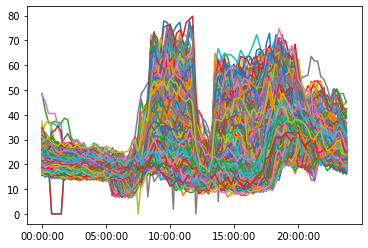

In [69]:
chart
chart.plot(legend=None)
plt.show()

In [70]:
chart.head()

,tue-2013-01-01,wed-2013-01-02,thu-2013-01-03,fri-2013-01-04,sat-2013-01-05,sun-2013-01-06,mon-2013-01-07,tue-2013-01-08,wed-2013-01-09,thu-2013-01-10,fri-2013-01-11,sat-2013-01-12,sun-2013-01-13,mon-2013-01-14,tue-2013-01-15,wed-2013-01-16,thu-2013-01-17,fri-2013-01-18,sat-2013-01-19,sun-2013-01-20,mon-2013-01-21,tue-2013-01-22,wed-2013-01-23,thu-2013-01-24,fri-2013-01-25,sat-2013-01-26,sun-2013-01-27,mon-2013-01-28,tue-2013-01-29,wed-2013-01-30,thu-2013-01-31,fri-2013-02-01,sat-2013-02-02,sun-2013-02-03,mon-2013-02-04,tue-2013-02-05,wed-2013-02-06,thu-2013-02-07,fri-2013-02-08,sat-2013-02-09,...,sat-2014-11-22,sun-2014-11-23,mon-2014-11-24,tue-2014-11-25,wed-2014-11-26,thu-2014-11-27,fri-2014-11-28,sat-2014-11-29,sun-2014-11-30,mon-2014-12-01,tue-2014-12-02,wed-2014-12-03,thu-2014-12-04,fri-2014-12-05,sat-2014-12-06,sun-2014-12-07,mon-2014-12-08,tue-2014-12-09,wed-2014-12-10,thu-2014-12-11,fri-2014-12-12,sat-2014-12-13,sun-2014-12-14,mon-2014-12-15,tue-2014-12-16,wed-2014-12-17,thu-2014-12-18,fri-2014-12-19,sat-2014-12-20,sun-2014-12-21,mon-2014-12-22,tue-2014-12-23,wed-2014-12-24,thu-2014-12-25,fri-2014-12-26,sat-2014-12-27,sun-2014-12-28,mon-2014-12-29,tue-2014-12-30,wed-2014-12-31
00:00:00,31.133250,22.415940,21.793275,23.661270,19.925280,27.397260,21.793275,23.038605,21.170610,21.793275,21.793275,23.661270,24.906600,23.661270,24.283935,21.793275,21.793275,21.170610,21.170610,24.283935,23.038605,22.415940,21.170610,21.793275,23.661270,19.925280,26.151930,17.434620,19.302615,21.17061,19.302615,20.547945,21.793275,21.793275,19.302615,18.679950,21.793275,19.925280,18.679950,22.415940,...,25.529265,19.925280,17.434620,18.057285,19.302615,19.302615,18.057285,20.547945,21.170610,20.547945,19.302615,20.547945,17.434620,18.679950,19.302615,25.529265,19.925280,17.43462,17.434620,17.434620,23.038605,24.906600,29.265255,22.415940,23.038605,25.529265,23.038605,19.925280,22.415940,24.283935,29.887920,26.774595,25.529265,25.529265,23.661270,21.170610,31.133250,28.642590,29.265255,24.906600
00:15:00,28.642590,22.415940,21.170610,22.415940,19.302615,25.529265,21.793275,24.283935,22.415940,19.302615,21.793275,23.038605,26.774595,23.661270,21.170610,19.925280,19.925280,19.925280,19.925280,22.415940,22.415940,24.283935,22.415940,21.793275,21.170610,18.679950,26.151930,18.679950,18.679950,21.17061,20.547945,19.302615,19.925280,21.170610,18.679950,18.057285,21.170610,19.302615,17.434620,21.170610,...,24.283935,20.547945,18.679950,18.679950,19.302615,20.547945,18.679950,20.547945,21.793275,19.302615,18.057285,18.679950,17.434620,18.057285,19.925280,23.038605,18.679950,17.43462,16.811955,18.057285,24.283935,23.038605,31.755915,23.661270,24.283935,22.415940,21.793275,21.793275,21.170610,24.283935,28.019925,28.019925,24.906600,25.529265,23.038605,21.793275,29.265255,29.887920,29.887920,26.774595
00:30:00,27.397260,20.547945,20.547945,22.415940,19.925280,24.283935,21.793275,21.170610,21.170610,19.302615,20.547945,23.038605,23.661270,23.038605,20.547945,20.547945,23.038605,19.302615,19.925280,23.038605,21.793275,24.906600,21.793275,21.170610,19.925280,18.057285,24.283935,18.679950,17.434620,18.67995,19.302615,19.302615,21.170610,19.925280,18.679950,18.679950,19.302615,18.057285,18.679950,20.547945,...,18.679950,19.925280,17.434620,17.434620,18.679950,19.925280,17.434620,19.302615,21.793275,19.302615,17.434620,18.057285,18.057285,18.679950,20.547945,22.415940,19.302615,17.43462,16.811955,17.434620,26.151930,21.170610,29.265255,21.793275,23.661270,22.415940,21.170610,21.170610,21.793275,24.283935,25.529265,25.529265,23.038605,26.151930,23.038605,21.170610,28.019925,27.397260,30.510585,23.661270
00:45:00,24.906600,20.547945,19.925280,21.793275,19.302615,23.661270,21.170610,21.170610,19.302615,18.057285,19.925280,24.283935,21.793275,21.170610,19.925280,18.057285,21.170610,19.302615,19.302615,23.661270,19.925280,22.415940,19.925280,19.302615,18.057285,18.679950,24.906600,19.302615,16.811955,16.18929,18.679950,19.925280,21.170610,20.547945,21.793275,18.6

## Run function to get optimal number of clusters
Again, the number of clusters represent the # of broad groupings between instances

In [72]:
getOptimalClusters(X, max_K=15)
np.max(silhouette_avgs)


print("Silhouette Averages: ", silhouette_avgs)
print("Inertia_1 Averages: ", inertias_1)

silhouette_plt = pd.DataFrame(silhouette_avgs, columns=['Silhouette']).reset_index()
inertias_plt = pd.DataFrame(inertias_1, columns=['Inertia']).reset_index()


Silhouette Averages:  [0.5011374240143703, 0.2821977416156188, 0.2811100481847252, 0.21965915775778697, 0.19252971651945266, 0.18027475571104937, 0.18373806884169414, 0.18809023366827565, 0.17641646008394868, 0.17410952372263727, 0.17433896730150597, 0.16821488389884842, 0.1485199468436473, 0.12300392845981299]
Inertia_1 Averages:  [6158002.739347876, 2599946.1576933423, 2126832.5224953373, 1864480.7882659277, 1708131.585853497, 1591363.1456121658, 1518731.926086461, 1443187.9414117965, 1395623.762149361, 1354918.5481024964, 1317464.0813858313, 1282096.3995526938, 1258682.3662940958, 1232953.0227378507, 1208149.7056146965]


## Plot Silhouette and Inertia averages

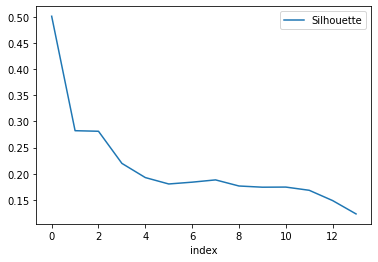

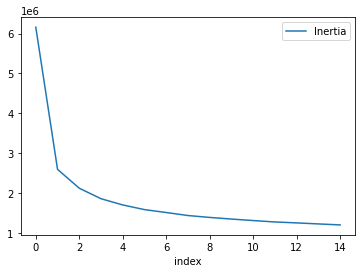

In [73]:
import matplotlib.pyplot as plt
silhouette_plt.plot(x='index',y='Silhouette')
inertias_plt.plot(x='index',y='Inertia')

Looking at above, it seems like we have two clusters to work with. k below represents the # of clusters

In [76]:
k=2
kmeans = KMeans(n_clusters=2)
y_pred = kmeans.fit_predict(X)
y_pred is kmeans.labels_

True

In [75]:
kmeans.labels_ # represents the cluster index each instance gets assigned to
labels = pd.DataFrame({'Date': daysyear, 'Cluster Idx': kmeans.labels_})
labels


,Date,Cluster Idx
0,tue-2013-01-01,1
1,wed-2013-01-02,0
2,thu-2013-01-03,0
3,fri-2013-01-04,0
4,sat-2013-01-05,1
...,...,...
725,sat-2014-12-27,0
726,sun-2014-12-28,1
727,mon-2014-12-29,0
728,tue-2014-12-30,0


Below shows what cluster is each instance is grouped to.

In [56]:
kmeans.labels_

array([1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,

# **Plotting each cluster**

## Isolate Cluster #1 instances

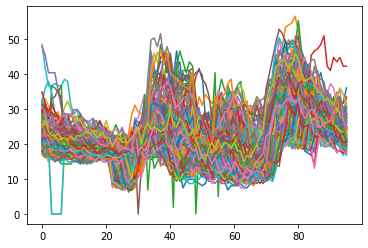

In [77]:
## These are cluster 1 points
from itertools  import compress
cluster_1= pd.DataFrame(list(compress(X, kmeans.labels_))).T
cluster_1.plot(legend=None)


### How many days are in first cluster?

In [78]:
print(str(sum(kmeans.labels_==0)), 'days')

511 days


## Isolate cluster #2 instances

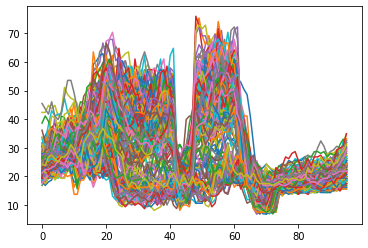

In [79]:
## these are 
cluster_2= pd.DataFrame(list(compress(np.flip(X), kmeans.labels_))).T
cluster_2.plot(legend=None)


### How many days are in second cluster?

In [80]:
print(str(sum(kmeans.labels_==1)), "days")

219 days


## Show only centroids of clusters, or the middle value of each cluster

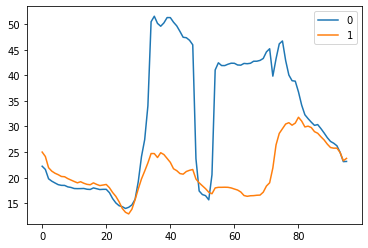

In [66]:
pd.DataFrame(kmeans.cluster_centers_).T.plot()

In [100]:
y_pred

array([1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,

# **What can we conclude?**
* The number of days in each cluster give ratios 5/7 and 2/7, so cluster 0 may be weekends, and cluster 1 weekdays. 
